# Confusion Matrix Code

In [1]:
import spacy
import json
import numpy as np
import pandas as pd
import os

In [2]:
ROOT_PATH = r"C:\Users\garsonj\Desktop\spacy_finetuning\spacy_files"

## True dataset

We build the data base to be treated

In [3]:
def import_label_studio_data(filename, target_labels):
    """
    This function imports the data from Label Studio JSON file and returns the data in the format required for training.
    It also allows to select specific labels to train the model on with the "target_labels" argument.
    """

    if not isinstance(target_labels, list):
        raise ValueError("The 'target_labels' argument must be a list of strings.")

    TRAIN_DATA = []  # Initialize TRAIN_DATA
    
    with open(filename, 'rb') as fp:
        training_data = json.load(fp)
    for text in training_data:
        entities = []
        info = text.get('text')
        entities = []
        if text.get('label') is not None:
            list_ = []
            for label in text.get('label'):
                list_.append([label.get('start'), label.get('end')])
            a = np.array(list_)
            overlap_ind = []
            for i in range(0, len(a[:, 0])):
                a_comp = a[i]
                x = np.delete(a, (i), axis=0)
                overlap_flag = any([a_comp[0] in range(j[0], j[1] + 1) for j in x])
                if overlap_flag:
                    overlap_ind.append(i)

            for ind, label in enumerate(text.get('label')):
                if ind in overlap_ind:
                    iop = 0
                else:
                    if any(target in label.get('labels') for target in target_labels):
                        entities.append((label.get('start'), label.get('end'), label.get('labels')[0]))
        
        if entities:  # Proceed only if there are non-empty entities
            TRAIN_DATA.append((info, {"entities": entities}))

    return TRAIN_DATA

# Call the function with the filename and a list of target labels
target_labels = ['OUV', 'INT', 'CAD', 'NOUV', 'NCAD', 'AG', 'AI', 'TOUS', 'AG OUV', 'AG INT', 'AG CAD', 'AI OUV', 'AI INT', 'AI CAD', 'NOUV AG', 'NCAD AG', 'NOUV AI', 'NCAD AI', 'ATOT',\
       'ATOT OUV', 'ATOT INT', 'ATOT CAD', 'PPV', 'PPVm', 'DATE'] # Add your target labels here

# all = ['OUV', 'INT', 'CAD', 'NOUV', 'NCAD', 'AG', 'AI', 'TOUS', 'AG OUV', 'AG INT', 'AG CAD', 'AI OUV', 'AI INT', 'AI CAD', 'NOUV AG', 'NCAD AG', 'NOUV AI', 'NCAD AI', 'ATOT',\
#        'ATOT OUV', 'ATOT INT', 'ATOT CAD', 'PPV', 'PPVm', 'DATE']

In [4]:
data_true = import_label_studio_data(os.path.join(ROOT_PATH, r"data\training_json\data449.json"), target_labels=target_labels)

In [5]:
# We make a data frame out of it with 1 when the label is present and 0 when it is not

def spacy_to_dataframe(data):
    """
    This function takes the data in the format returned by the import_label_studio_data function and returns a pandas dataframe of two columns: text and label.

    Args:
        data: The data in the format returned by the import_label_studio_data function.

    Returns:
        A pandas dataframe of two columns: text and label.
    """
    text_data = [text for text, _ in data]
    labels = [label for _, label in data]

    df = pd.DataFrame({'text': text_data, 'label': labels})
    return df

# text_data = [text for text, _ in data]
# labels = [label for _, label in data]

# df = pd.DataFrame({'text': text_data, 'label': labels})

df_true = spacy_to_dataframe(data_true)
df_true.tail()

,text,label
438,negociation annuelle 2022. il a été convenu et...,"{'entities': [(98, 106, 'OUV'), (325, 329, 'AG..."
439,négociations annuelles obligatoires. ii- dispo...,"{'entities': [(217, 221, 'AG'), (258, 287, 'TO..."
440,"accord collectif 2022 sur les salaires, la dur...","{'entities': [(360, 383, 'TOUS'), (476, 483, '..."
441,damart sa etablissement. article i : augmentat...,"{'entities': [(114, 122, 'OUV'), (124, 132, 'O..."
442,"entre l’ues kiabi, représentée par, directeur...","{'entities': [(704, 726, 'TOUS'), (764, 771, '..."


In [6]:
def dummy_label(df):
    """
    This function creates a dummy variable for the target label.

    Args:
        df (DataFrame): The DataFrame containing the text and label columns.
    """
    # Create a new column called "label_dummy" and initialize with zeros
    df["label_dummy"] = 0

    # Iterate through each row in the DataFrame
    for index, row in df.iterrows():
        labels = row["label"]["entities"]  # Access the entities list in the tuple
        for label in labels:
            target = label[2]
            if target == "PPV":
                df.at[index, "label_dummy"] = 1  # Set the value to 1 for the current row

    # Print the DataFrame to verify the changes
    print(df["label_dummy"].value_counts())
    return df

def clean_dataset(data):
    """
    This function cleans the dataset by removing rows with missing values and dropping the "label" column.
    It also renames the "label_dummy" column to "label".

    Args:
        data (DataFrame): The DataFrame containing the text, label and label_dummy columns.
    """
    data.dropna(axis=0, how='any', inplace=True)
    # Now we can drop the "label" column and rename the "label_dummy" column to "label"
    if 'label_dummy' in data.columns:
        data.drop("label", axis=1, inplace=True)
        data.rename(columns={"label_dummy": "label"}, inplace=True)
    else:
        pass
    print(data.head())
    return data

df_true = dummy_label(df_true)
df_true = clean_dataset(df_true)

label_dummy
0    349
1     94
Name: count, dtype: int64
                                                text  label
0  evolution des salaires de base : enveloppe bud...      0
1  l’enveloppe globale d’augmentation des rémunér...      0
2  dispositions au regard de l’implication de tou...      1
3  nous travaillons sur une politique de rémunéra...      1
4  protocole d’accord négociation annuelle obliga...      0


## Predicted dataset

Now we do the data set with the predicted answer

In [7]:
with open(os.path.join(ROOT_PATH, r"data\predicted_json\labeled_data_PPV.json"), "r", encoding="utf-8") as f:
    data_pred = json.load(f)

In [8]:
def dummy_label_pred(df):
    """
    This function creates a dummy variable for the target label.

    Args:
        df (DataFrame): The DataFrame containing the text and label columns.
    """
    # Create a new column called "label_dummy" and initialize with zeros
    df["label_dummy"] = 0

    for index, row in df_pred.iterrows():
        label_data = row['label']
        if label_data == {'label': []}:
            df_pred.at[index, 'label_dummy'] = 0
        else:
            df_pred.at[index, 'label_dummy'] = 1

    # Print the DataFrame to verify the changes
    print(df["label_dummy"].value_counts())
    return df



df_pred = spacy_to_dataframe(data_pred)
df_pred = dummy_label_pred(df_pred)
df_pred = clean_dataset(df_pred)
df_pred.head()

label_dummy
0    295
1    154
Name: count, dtype: int64
                                                text  label
0  evolution des salaires de base : enveloppe bud...      0
1  accord collectif relatif à la négociation annu...      1
2  société anonyme. les parties au présent accord...      1
3  accord collectif. la politique de rémunération...      1
4  accord salarial 2023. article 1- prime excepti...      1


,text,label
0,evolution des salaires de base : enveloppe bud...,0
1,accord collectif relatif à la négociation annu...,1
2,société anonyme. les parties au présent accord...,1
3,accord collectif. la politique de rémunération...,1
4,accord salarial 2023. article 1- prime excepti...,1


We order the two data sets

In [ ]:
df_whole = pd.merge(left=df_true, right=df_pred, on='text', how="inner")

## Plotting the matrix of confusion

In [28]:
true_label_data = df_whole['label_x'].tolist()
pred_label_data = df_whole['label_y'].tolist()

In [29]:
print(len(true_label_data))
print(len(pred_label_data))

445
445


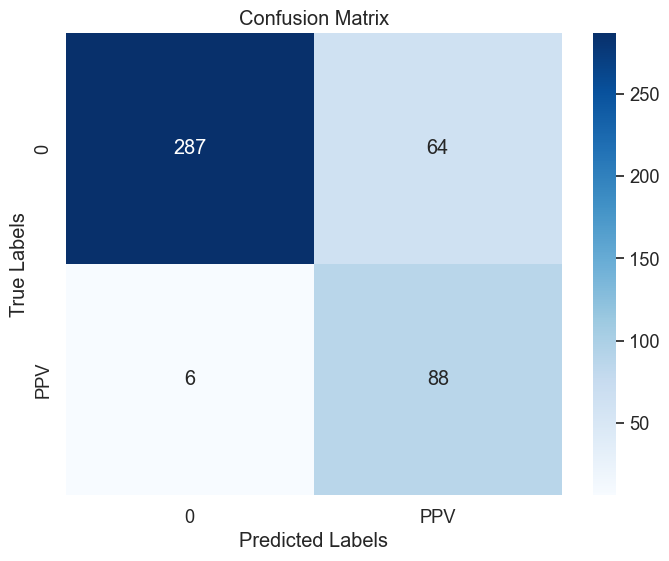

[[287  64]
 [  6  88]]


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(true_label_data, pred_label_data)

# Assuming you have already created the heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size if needed
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=['0', 'PPV'], yticklabels=['0', 'PPV'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print the values
print(confusion)


In [80]:
type(confusion)

numpy.ndarray

We display the key statistics

In [31]:
# Calculate True Positives (TP), False Positives (FP), and False Negatives (FN)
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
TP = confusion[1, 1]

# Calculate precision and recall
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Precision: 0.5789473684210527
Recall: 0.9361702127659575
F1 Score: 0.7154471544715447
